# Importing Dependencies

In [29]:
import os
import keras
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from typing import Dict, List, Tuple
from keras.applications import ResNet50V2
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model

# Cloning the Repository

In [7]:
# Cloning the repository
!git clone https://github.com/FabricioDosSantosMoreira/PlanetsVsGalaxiesClassifier.git

Cloning into 'PlanetsVsGalaxiesClassifier'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 298 (delta 10), reused 11 (delta 3), pack-reused 273 (from 2)
Receiving objects: 100% (298/298), 201.56 MiB | 45.03 MiB/s, done.
Resolving deltas: 100% (12/12), done.


# Defining Helper Functions

In [8]:
def resize_image(in_img_path: Path, out_img_path: Path, width: int, height: int) -> None:
    """
    Resizes an image and saves it to a new location.

    Args:
      in_img_path: Path to the input image file.
      out_img_path: Path to save the resized image file.
      width: The desired width of the resized image in pixels.
      height: The desired height of the resized image in pixels.

    Raises:
        OSError: If there is an error opening or saving the image files.
    """

    image = Image.open(in_img_path)

    # NOTE: Formatting the file name for better clarity
    out_path = out_img_path.with_name(out_img_path.name.replace('[ORIGINAL]', '[RESIZED]'))

    # Resizing and saving the image
    resized_image = image.resize((width, height))
    resized_image.save(out_path)


def rotate_image(in_img_path: Path, out_img_path: Path, angle_step: int) -> None:
    """
    Rotates an image by a specified angle step and saves the resulting images.

    Args:
        in_img_path: Path to the input image file.
        out_img_path: Path to the output image file.
        angle_step: The angle step for rotation (default: 5 degrees).

    Raises:
        OSError: If there is an error opening or saving the image files.
    """

    image = Image.open(in_img_path)

    # Rotates from 10° to 350° by a step of angle_step
    for angle in range(10, 360, angle_step):

        # NOTE: Formatting the file name for better clarity
        out_path = out_img_path.with_name(out_img_path.name.replace('[RESIZED]', f'[ROTATED {angle}°]'))

        # Rotating and saving the image
        rotated_image = image.rotate(angle, expand=True)
        rotated_image.save(out_path)


def split_dataset(dataset_path: Path, train_dir: Path, test_dir: Path, val_dir: Path, train_ratio: int = 0.8, val_ratio: int = 0.1) -> None:
    """
    Splits the dataset into training, testing and validation.

    Args:
        dataset_path: Path to the directory containing the original dataset.
        train_dir: Path to the directory where the training set will be stored.
        test_dir: Path to the directory where the testing set will be stored.
        val_dir: Path to the directory where the validation set will be stored.
        train_ratio: Proportion of the dataset to be used for training (default: 0.8).
        val_ratio: Proportion of the dataset to be used for validation (default: 0.1).
    """

    if train_ratio + val_ratio >= 1.0:
        raise ValueError("Train and validation ratios must sum to a value less than 1.0.")

    if not train_dir.is_dir or not val_dir.is_dir or not test_dir.is_dir:
        raise ValueError("The specified directories do not exist.")


    for subdir in ["Galaxies", "Planets"]:

        # Defining the subdirs paths
        source_subdir = Path(dataset_path / subdir)
        train_subdir = Path(train_dir / subdir)
        test_subdir = Path(test_dir / subdir)
        val_subdir = Path(val_dir / subdir)

        # Creating the paths
        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(val_subdir, exist_ok=True)
        os.makedirs(test_subdir, exist_ok=True)

        # Get all images paths from 'source_subdir' and shuffles it
        images: List[Path] = [file for file in os.listdir(source_subdir) if os.path.isfile(Path(source_subdir / file))]
        random.shuffle(images)

        num_images: int = len(images)


        # Defining the splits
        train_split: int = int(num_images * train_ratio)
        val_split:   int = int(num_images * (train_ratio + val_ratio))

        # Defining the images for train, test and validation
        train_images: List[Path] = images[:train_split]
        test_images:  List[Path] = images[val_split:]
        val_images:   List[Path] = images[train_split:val_split]

        # Copying the train images to the designed train dir
        for image in train_images:
            source_path = os.path.join(source_subdir, image)
            destination_path = os.path.join(train_subdir, image)
            shutil.copy2(source_path, destination_path)

        # Copying the test images to the designed test dir
        for image in test_images:
            source_path = os.path.join(source_subdir, image)
            destination_path = os.path.join(test_subdir, image)
            shutil.copy2(source_path, destination_path)

        # Copying the val images to the designed val dir
        for image in val_images:
            source_path = os.path.join(source_subdir, image)
            destination_path = os.path.join(val_subdir, image)
            shutil.copy2(source_path, destination_path)


def print_dir_counts(dir_path: Path) -> None:
    """
    Prints the number of images in each subdirectory within the given directory.

    Args:
        dir_path (Path): The path to the directory containing subdirectories.
    """

    for subdir in ['Galaxies', 'Planets']:
        subdir_path = dir_path / subdir
        num_images = len(os.listdir(subdir_path))

        print(f"Images inside {subdir_path}: {num_images}")

# Adjusting the Dataset

## Defining Path Variables

In [9]:
# Defining the repository path
REPO_PATH = Path('./PlanetsVsGalaxiesClassifier/')

# Defining the dataset and folders path
DATASET_PATH = Path(REPO_PATH / './Dataset')
PLANETS_FOLDER = Path(DATASET_PATH / 'Planets/')
GALAXIES_FOLDER = Path(DATASET_PATH / 'Galaxies/')

# Defining the modified dataset and folders path
MODIFIED_DATASET_PATH = Path('./Modified Dataset')
MODIFIED_PLANETS_FOLDER = Path(MODIFIED_DATASET_PATH / 'Planets/')
MODIFIED_GALAXIES_FOLDER = Path(MODIFIED_DATASET_PATH / 'Galaxies/')

# Creating the modified folders
os.makedirs(MODIFIED_GALAXIES_FOLDER, exist_ok=True)
os.makedirs(MODIFIED_PLANETS_FOLDER, exist_ok=True)

## Performing a Manual Resizing on the Dataset

In [10]:
should_resize_n_galaxies: int = len(os.listdir(GALAXIES_FOLDER))
should_resize_n_planets:  int = len(os.listdir(PLANETS_FOLDER))
resized_n_galaxies: int = 0
resized_n_planets:  int = 0

WIDTH:  int = 654
HEIGHT: int = 654

SILENT: bool = True


# Resizing all planets images from 'Dataset/Planets' to 'Modified Dataset/Planets'
for file in os.listdir(PLANETS_FOLDER):
    file = Path(file)

    resize_image(
        in_img_path=Path(PLANETS_FOLDER / file),
        out_img_path=Path(MODIFIED_PLANETS_FOLDER / file),
        width=WIDTH,
        height=HEIGHT,
    )

    resized_n_planets += 1
    if not SILENT:
        print(f'Successfully resized:   {file.name}!')

# Resizing all galaxies images from 'Dataset/Galaxies' to 'Modified Dataset/Galaxies'
for file in os.listdir(GALAXIES_FOLDER):
    file = Path(file)

    resize_image(
        in_img_path=Path(GALAXIES_FOLDER / file),
        out_img_path=Path(MODIFIED_GALAXIES_FOLDER / file),
        width=WIDTH,
        height=HEIGHT,
    )

    resized_n_galaxies += 1
    if not SILENT:
        print(f'Successfully resized:   {file.name}!')


print(f'\nResized a total of: {resized_n_galaxies} galaxies image files. Should have resized: {should_resize_n_galaxies} files.')
print(f'\nResized a total of: {resized_n_planets} planets image files. Should have resized: {should_resize_n_planets} files.')


Resized a total of: 130 galaxies image files. Should have resized: 130 files.

Resized a total of: 130 planets image files. Should have resized: 130 files.


## Performing a Manual Data Augmentation on the Dataset


In [11]:
should_rotate_n_galaxies: int = len(os.listdir(MODIFIED_GALAXIES_FOLDER))
should_rotate_n_planets:  int = len(os.listdir(MODIFIED_PLANETS_FOLDER))
rotated_n_galaxies: int = 0
rotated_n_planets:  int = 0

ANGLE_STEP: int = 15

SILENT: bool = True


# Performing a data augmentation on the planets images
for file in os.listdir(MODIFIED_PLANETS_FOLDER):
    file = Path(file)

    rotate_image(
        in_img_path=Path(MODIFIED_PLANETS_FOLDER / file),
        out_img_path=Path(MODIFIED_PLANETS_FOLDER / file),
        angle_step=ANGLE_STEP
    )

    rotated_n_planets += 1
    if not SILENT:
        print(f'Successfully rotated   {file.name}!')

# Performing a data augmentation on the galaxies images
for file in os.listdir(MODIFIED_GALAXIES_FOLDER):
    file = Path(file)

    rotate_image(
        in_img_path=Path(MODIFIED_GALAXIES_FOLDER / file),
        out_img_path=Path(MODIFIED_GALAXIES_FOLDER / file),
        angle_step=ANGLE_STEP
    )

    rotated_n_galaxies += 1
    if not SILENT:
        print(f'Successfully rotated   {file.name}!')


# Displaying infos
print(f'\nRotated a total of: {rotated_n_galaxies} galaxies image files. Should have rotated: {should_rotate_n_galaxies} files.')
print(f'\nRotated a total of: {rotated_n_planets} planets image files. Should have rotated: {should_rotate_n_planets} files.')


Rotated a total of: 130 galaxies image files. Should have rotated: 130 files.

Rotated a total of: 130 planets image files. Should have rotated: 130 files.


## Splitting the Dataset into Training, Testing and Validation.

In [12]:
TRAIN_DIR = Path('./Train')
TEST_DIR = Path('./Test')
VAL_DIR = Path('./Val')

# NOTE: 'TRAIN_RATIO' and 'VAL_RATIO' shouldn't add to 1.
TRAIN_RATIO: int = 0.70
VAL_RATIO: int = 0.27

# Splitting the dataset
split_dataset(MODIFIED_DATASET_PATH, TRAIN_DIR, TEST_DIR, VAL_DIR, TRAIN_RATIO, VAL_RATIO)


# Displaying infos
print("Training Set:")
print_dir_counts(TRAIN_DIR)

print("\nTest Set:")
print_dir_counts(TEST_DIR)

print("\nValidation Set:")
print_dir_counts(VAL_DIR)

Training Set:
Images inside Train/Galaxies: 2275
Images inside Train/Planets: 2275

Test Set:
Images inside Test/Galaxies: 98
Images inside Test/Planets: 98

Validation Set:
Images inside Val/Galaxies: 877
Images inside Val/Planets: 877


## Loading the Datasets

In [13]:
BATCH_SIZE: int = 32
IMG_SIZE: Tuple[int, int] = (WIDTH, HEIGHT)
CLASS_NAMES: List[str] = ['Galaxies', 'Planets']

# Train, test and validation datasets
TRAIN_DATASET = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    class_names=CLASS_NAMES
)

TEST_DATASET = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    class_names=CLASS_NAMES
)

VAL_DATASET = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    class_names=CLASS_NAMES
)

Found 4550 files belonging to 2 classes.
Found 196 files belonging to 2 classes.
Found 1754 files belonging to 2 classes.


## Displaying Training Images from the Dataset

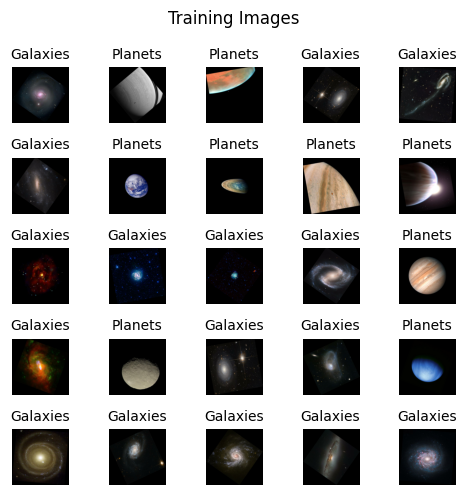

In [14]:
plt.figure(figsize=(5, 5))
plt.suptitle("Training Images", fontsize=12, ha='center')

for images, labels in TRAIN_DATASET.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]], fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

# Preparing the Model

## Autotune

In [15]:
# Performance pipeline
AUTOTUNE = tf.data.AUTOTUNE

TRAIN_DATASET = TRAIN_DATASET.prefetch(buffer_size=AUTOTUNE)
TEST_DATASET = TEST_DATASET.prefetch(buffer_size=AUTOTUNE)
VAL_DATASET = VAL_DATASET.prefetch(buffer_size=AUTOTUNE)

## Defining the Model Class

In [16]:
class CustomModel():

    def __init__(self, img_shape: Tuple[int, int, int], num_classes: int) -> None:
        self.img_shape = img_shape
        self.num_classes = num_classes


    def create_model(self) -> tf.keras.Model:
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=self.img_shape)
        base_model.trainable = True

        for layer in base_model.layers[:100]:
          layer.trainable = False

        global_average_layer = layers.GlobalAveragePooling2D()
        batch_norm_layer = layers.BatchNormalization()
        dropout_layer = layers.Dropout(0.5)
        output_layer = layers.Dense(1, activation='sigmoid')

        inputs = tf.keras.Input(shape=self.img_shape)
        x = base_model(inputs, training=False)
        x = global_average_layer(x)
        x = batch_norm_layer(x)
        x = dropout_layer(x)
        outputs = output_layer(x)

        model = Model(inputs, outputs)
        return model

## Starting the Model

In [17]:
# Model configs
IMG_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 2

# Starting the model
model = CustomModel(IMG_SHAPE, NUM_CLASSES).create_model()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Compiling the Model for Evaluation and Pre-Training

In [18]:
BASE_LEARNING_RATE: float = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


# Displaying info
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 654, 654, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 21, 21, 2048)        │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,575,041 (89.93 MB)

 Trainable params: 20,566,017 (78.45 MB)

 Non-trainable params: 3,009,024 (11.48 MB)

## Evaluating the Model without Pre-Training

In [19]:
# Evaluating the Model
initial_loss, initial_binary_accuracy, initial_precision, initial_recall = model.evaluate(TEST_DATASET)

print(f'\nInitial Evaluation without Pre-Training:')
print(f'Initial loss: {initial_loss}')
print(f'Initial accuracy: {initial_binary_accuracy}')
print(f'Initial precision: {initial_precision}')
print(f'Initial recall: {initial_recall}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7566 - loss: 1.2670 - precision: 0.8265 - recall: 0.6271

Initial Evaluation without Pre-Training:
Initial loss: 1.165627360343933
Initial accuracy: 0.75
Initial precision: 0.8266666531562805
Initial recall: 0.6326530575752258


## Evaluating the Model with Pre-Training

In [20]:
INITIAL_EPOCHS: int = 3

# Pre-Training the Model
initial_history = model.fit(
    TRAIN_DATASET,
    validation_data=VAL_DATASET,
    epochs=INITIAL_EPOCHS
)

# Evaluating the Model
initial_loss, initial_binary_accuracy, initial_precision, initial_recall = model.evaluate(TEST_DATASET)

print(f'\nInitial Evaluation with Pre-Training:')
print(f'Initial loss: {initial_loss}')
print(f'Initial accuracy: {initial_binary_accuracy}')
print(f'Initial precision: {initial_precision}')
print(f'Initial recall: {initial_recall}')

Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.9209 - loss: 0.1920 - precision: 0.9509 - recall: 0.8874 - val_accuracy: 0.9504 - val_loss: 0.1595 - val_precision: 1.0000 - val_recall: 0.9008
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9817 - loss: 0.0510 - precision: 0.9875 - recall: 0.9771 - val_accuracy: 0.9966 - val_loss: 0.0293 - val_precision: 1.0000 - val_recall: 0.9932
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9849 - loss: 0.0388 - precision: 0.9883 - recall: 0.9817 - val_accuracy: 0.9983 - val_loss: 0.0118 - val_precision: 0.9977 - val_recall: 0.9989
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 1.0000 - loss: 0.0117 - precision: 1.0000 - recall: 1.0000

Initial Evaluation with Pre-Training:
Initial loss: 0.008044461719691753
Initial accuracy: 1.0
Initial precision: 1.0
Initial recall: 1.0


## Compiling the Model for Training

In [21]:
LEARNING_RATE: float = 0.001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

## Training the Compiled Model

In [22]:
EPOCHS: int = 10

# Training the Model
fine_history = model.fit(
    TRAIN_DATASET,
    validation_data=VAL_DATASET,
    epochs=EPOCHS
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9397 - loss: 0.1800 - precision: 0.9531 - recall: 0.9265 - val_accuracy: 0.6328 - val_loss: 7.9429 - val_precision: 0.5773 - val_recall: 0.9920
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.9784 - loss: 0.0651 - precision: 0.9782 - recall: 0.9787 - val_accuracy: 0.9259 - val_loss: 0.2207 - val_precision: 0.8716 - val_recall: 0.9989
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9878 - loss: 0.0486 - precision: 0.9841 - recall: 0.9915 - val_accuracy: 0.9835 - val_loss: 0.0652 - val_precision: 0.9680 - val_recall: 1.0000
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9910 - loss: 0.0263 - precision: 0.9897 - recall: 0.9925 - val_accuracy: 0.8877 - val_loss: 0.7073 - val_precision: 0.9913 - val_recall: 0.7822
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9850 - loss: 0.0474 - precision: 0.9844 - recall: 0.9861 - val_accuracy: 0.9920 - val_los

# Displaying Model Results

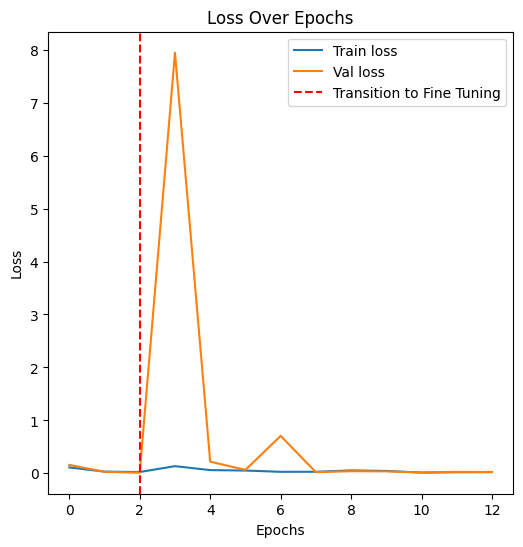

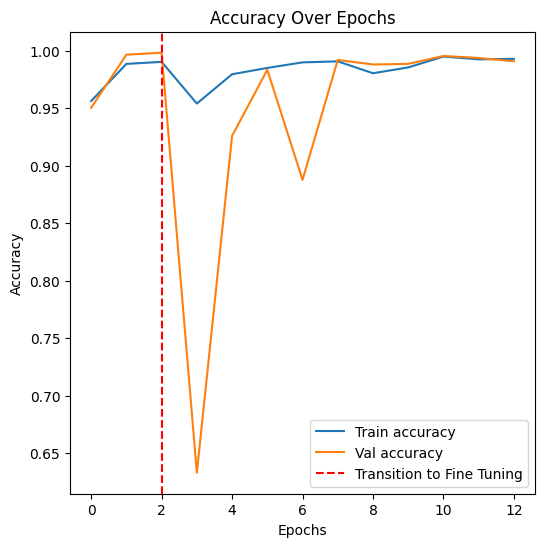

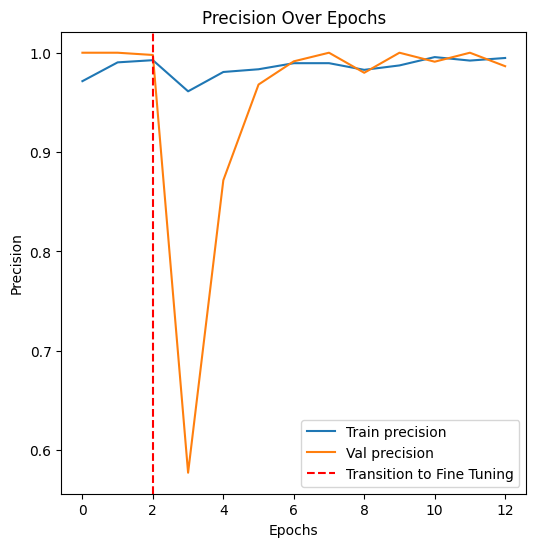

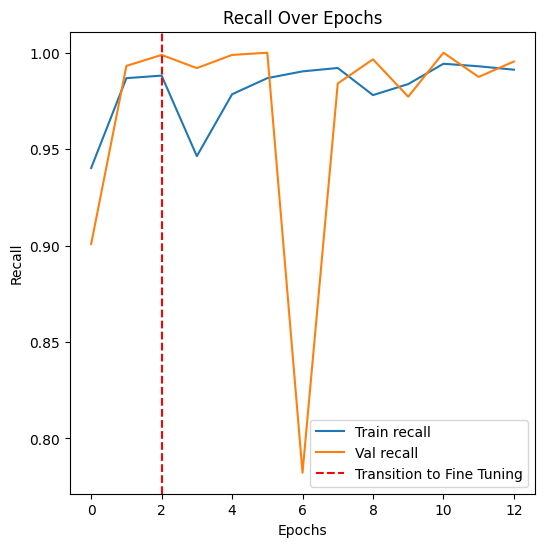

In [23]:
def combine_and_plot_histories(initial_history, fine_history) -> None:

    # Combining both histories
    combined_history: Dict[str, float] = {
        'loss': initial_history.history['loss'] + fine_history.history['loss'],
        'val_loss': initial_history.history['val_loss'] + fine_history.history['val_loss'],
        'accuracy': initial_history.history['accuracy'] + fine_history.history['accuracy'],
        'val_accuracy': initial_history.history['val_accuracy'] + fine_history.history['val_accuracy'],
        'precision': initial_history.history['precision'] + fine_history.history['precision'],
        'val_precision': initial_history.history['val_precision'] + fine_history.history['val_precision'],
        'recall': initial_history.history['recall'] + fine_history.history['recall'],
        'val_recall': initial_history.history['val_recall'] + fine_history.history['val_recall']
    }
    metrics: List[str] = ['loss', 'accuracy', 'precision', 'recall']

    # Plotting the data
    for metric in metrics:
        plt.figure(figsize=(6, 6))

        plt.plot(combined_history[metric], label=f'Train {metric}')
        plt.plot(combined_history[f'val_{metric}'], label=f'Val {metric}')

        plt.title(f'{metric.title()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())

        plt.axvline(x=len(initial_history.history[metric]) - 1, color='red', linestyle='--', label='Transition to Fine Tuning')
        plt.legend()
        plt.show()


combine_and_plot_histories(initial_history, fine_history)

# Saving the Model

In [24]:
# Save the model
model.save('PlanetsVsGalaxiesModel.keras')

# Predicting with the Trained Model

## Loading the Model (Optional)

In [25]:
LOAD_TRAINED_MODEL_FROM_REPO: bool = False

# Load the trained model from the repository
if LOAD_TRAINED_MODEL_FROM_REPO:
    model = load_model('./PlanetsVsGalaxiesModel.keras')

## Making Predictions with the Test Dataset


Results:
Predicted:   [0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1]
True labels: [0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1]



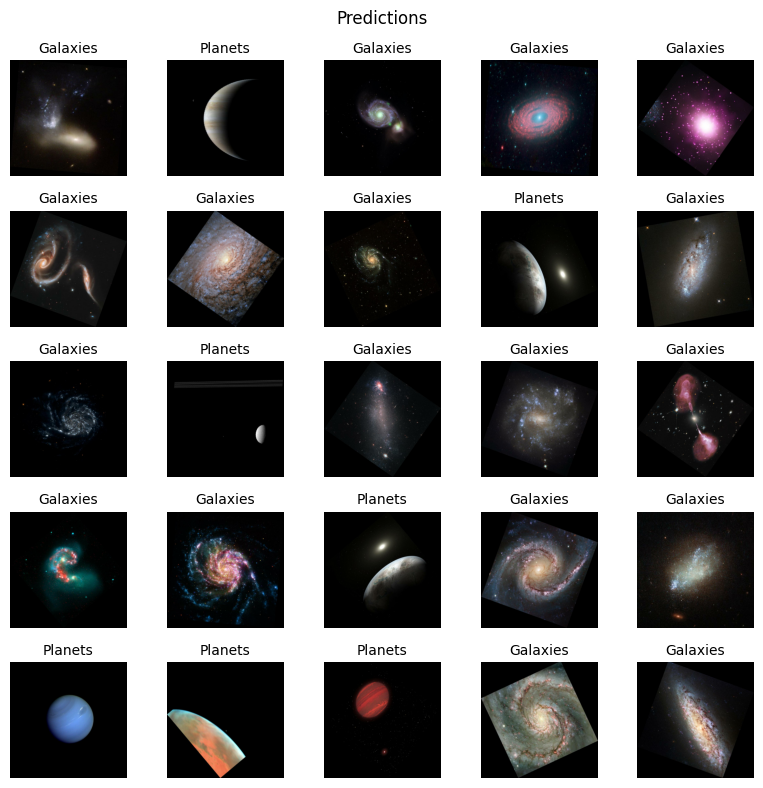

In [26]:
# Retrieving a batch of images from the test set
image_batch, label_batch = TEST_DATASET.as_numpy_iterator().next()

# Predicting
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)



print('\nResults:')
print(f'Predicted:   {predictions.numpy()}')
print(f'True labels: {label_batch}\n')


# Plotting the data
plt.figure(figsize=(8, 8))
plt.suptitle('Predictions', fontsize=12, ha='center')
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(CLASS_NAMES[predictions[i]], fontsize=10)
  plt.axis("off")

plt.tight_layout()
plt.show()

Found 20 files belonging to 2 classes.

Results:
Predicted:   [0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0]
True labels: [0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0]



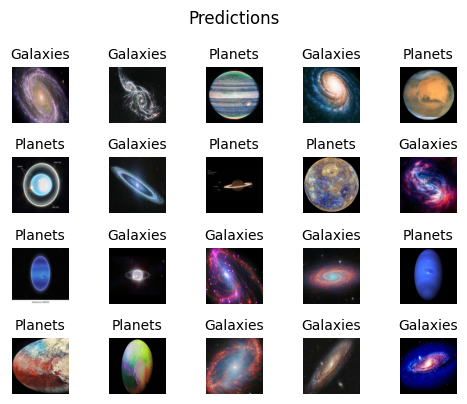

In [27]:
WEB_IMAGES_PATH = Path('./WEBImages')

os.makedirs(WEB_IMAGES_PATH / 'Galaxies', exist_ok=True)
os.makedirs(WEB_IMAGES_PATH / 'Planets', exist_ok=True)

# Downloading example images
!wget  -q https://img.freepik.com/premium-photo/space-stars-galaxies-background-digital-illustration_160901-5977.jpg -O './WEBImages/Galaxies/g0.jpg'
!wget  -q https://ichef.bbci.co.uk/ace/standard/976/cpsprodpb/092F/production/_123315320_gettyimages-85757595.jpg    -O './WEBImages/Galaxies/g1.jpg'
!wget  -q https://i.natgeofe.com/n/e484088d-3334-4ab6-9b75-623f7b8505c9/1086_2x1.jpg                                 -O './WEBImages/Galaxies/g2.jpg'
!wget  -q https://live.staticflickr.com/65535/54213026331_1db54389b6_k_d.jpg                                         -O './WEBImages/Galaxies/g3.jpg'
!wget  -q https://live.staticflickr.com/65535/54167157727_43b6ffe5e2_b_d.jpg                                         -O './WEBImages/Galaxies/g4.jpg'
!wget  -q https://live.staticflickr.com/65535/54163774891_19ed107c9e_k_d.jpg                                         -O './WEBImages/Galaxies/g5.jpg'
!wget  -q https://live.staticflickr.com/65535/54107470055_bdad060532_k_d.jpg                                         -O './WEBImages/Galaxies/g6.jpg'
!wget  -q https://live.staticflickr.com/65535/53850188868_e2ab4cdb95_k_d.jpg                                         -O './WEBImages/Galaxies/g7.jpg'
!wget  -q https://upload.wikimedia.org/wikipedia/commons/5/54/Galaxy_blue.jpg                                        -O './WEBImages/Galaxies/g8.jpg'
!wget  -q https://cdn.mos.cms.futurecdn.net/hCXYB5YKXzdq2WEHYEe36d.jpg                                               -O './WEBImages/Galaxies/g9.jpg'

!wget  -q https://www.shutterstock.com/image-illustration/neptune-rotating-on-outer-space-260nw-2044027325.jpg  -O './WEBImages/Planets/p0.jpg'
!wget  -q https://www.techexplorist.com/wp-content/uploads/2022/07/pluto-696x391.jpg                            -O './WEBImages/Planets/p1.jpg'
!wget  -q https://cdn.esahubble.org/archives/images/thumb700x/opo0124a.jpg                                      -O './WEBImages/Planets/p2.jpg'
!wget  -q https://stsci-opo.org/STScI-01HCX1BZNYYEKX2WF7KAGQVMG2.jpg                                            -O './WEBImages/Planets/p3.jpg'
!wget  -q https://stsci-opo.org/STScI-01GWQDRKGKCTJZYARW1GGYZ7ZM.png                                            -O './WEBImages/Planets/p4.jpg'
!wget  -q https://stsci-opo.org/STScI-01GCVNBXMMFH135VNSB3ZN3304.png                                            -O './WEBImages/Planets/p5.jpg'
!wget  -q https://stsci-opo.org/STScI-01H41MMJCQDX320MNVCNRE096C.png                                            -O './WEBImages/Planets/p6.jpg'
!wget  -q https://cdn.mos.cms.futurecdn.net/PezBzd9Fehsq9XWgWMauVV.jpg                                          -O './WEBImages/Planets/p7.jpg'
!wget  -q https://scx2.b-cdn.net/gfx/news/hires/2015/whatsimporta.jpg                                           -O './WEBImages/Planets/p8.jpg'
!wget  -q https://i.redd.it/lz1ewpw693t91.jpg                                                                   -O './WEBImages/Planets/p9.jpg'


# Loading the downloaded images as a dataset
TEMP_DATASET = tf.keras.preprocessing.image_dataset_from_directory(
    WEB_IMAGES_PATH,
    shuffle=True,
    batch_size=20,
    image_size=IMG_SIZE,
    class_names=CLASS_NAMES
)

# Retrieving a batch of images from the temp dataset
image_batch, label_batch = TEMP_DATASET.as_numpy_iterator().next()

# Predicting
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)


print('\nResults:')
print(f'Predicted:   {predictions.numpy()}')
print(f'True labels: {label_batch}\n')


# Plotting the data
plt.figure(figsize=(5, 5))
plt.suptitle('Predictions', fontsize=12, ha='center')
for i in range(20):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(CLASS_NAMES[predictions[i]], fontsize=10)
  plt.axis("off")

plt.tight_layout()
plt.show()

## Making Predictions with WEB Images

## Making Predictions with Uploaded Files

In [28]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('\n')

    path = Path('/content/' + fn)

    if path.suffix not in ['.jpg', '.png']:
        raise ValueError('Invalid image format!')

    # Load and pre-process image
    image = keras.utils.load_img(path, target_size=IMG_SIZE)
    input_arr = keras.utils.img_to_array(image)
    input_arr = np.array([input_arr])

    # Predict
    predicted_class = model.predict(input_arr, batch_size=1)[0][0]
    print(f'Predicted class: {predicted_class}')

    if predicted_class > 0.5:
        print(f"'{fn}' is a Planet!")
    else:
        print(f"'{fn}' is a Galaxy!")


Saving 4 - Planet Image.jpg to 4 - Planet Image.jpg
Saving 4 - Galaxy Image.jpg to 4 - Galaxy Image.jpg
Saving 3 - Galaxy Image.jpg to 3 - Galaxy Image.jpg
Saving 1 - Planet Image.jpg to 1 - Planet Image.jpg
Saving 2 - Planet Image.jpg to 2 - Planet Image.jpg
Saving 2 - Galaxy Image.jpg to 2 - Galaxy Image.jpg
Saving 1 - Galaxy Image.jpg to 1 - Galaxy Image.jpg
Saving 3 - Planet Image.jpg to 3 - Planet Image.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted class: 1.0
'4 - Planet Image.jpg' is a Planet!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: 3.745705006683324e-23
'4 - Galaxy Image.jpg' is a Galaxy!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: 0.032060831785202026
'3 - Galaxy Image.jpg' is a Galaxy!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: 1.0
'1 - Planet Image.jpg' is a Planet!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: 1.0
'2 - Planet Image.jpg' is a Planet!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: 0.0014409